# Espectro IR usando VASP e ASE

Autor: [Prof. Elvis do A. Soares](https://github.com/elvissoares) 

Contato: [elvis@peq.coppe.ufrj.br](mailto:elvis@peq.coppe.ufrj.br) - [Programa de Engenharia Química, PEQ/COPPE, UFRJ, Brasil](https://www.peq.coppe.ufrj.br/)

---

Importando variáveis do VASP

In [1]:
import os
# Definindo o path para os arquivos de potencial de pseudopotenciais do VASP
# Certifique-se de que o caminho esteja correto para o seu sistema
os.environ['VASP_PP_PATH'] = '/home/elvis/Programs/vasp-6.5.1/pp'
os.environ['ASE_VASP_COMMAND'] = 'mpirun -np 1 vasp_std_gpu'
os.environ['NO_STOP_MESSAGE'] = '1' # to avoid warning from mpirun

# Importando o VASP calculator do ASE
from ase.calculators.vasp import Vasp

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from ase.io import write, read
from ase.visualize import view
from ase.build import molecule

# Calculando espectro IR pelo ASE

## Molécula de H2O

Lendo a geometria da água otimizada na aula passada

In [68]:
calc = Vasp(restart=True,directory='water/relaxed')
water = calc.get_atoms()

Definindo a calculadora para o Infrared

In [33]:
# now define a new calculator
calc = Vasp(directory="water/ir_calculation",
        xc="PBE",
        prec='Accurate',
        ediff=1E-8,
        isym=0,
        ibrion=-1,
        ldipol=True, 
        idipol = 4,            # full 3D dipole (molecules)
        dipol=water.get_center_of_mass(scaled=True), # dipole position is CM
        atoms=water)

In [34]:
from ase.vibrations import Infrared

ir = Infrared(water,name='water/ir')
ir.run()
ir.summary()

-------------------------------------
 Mode    Frequency        Intensity
  #    meV     cm^-1   (D/Å)^2 amu^-1
-------------------------------------
  0   13.9i    112.1i     5.1731
  1   13.5i    109.1i     1.8115
  2    8.6i     69.5i     0.0000
  3    0.1i      1.0i     0.0000
  4    1.1       8.7      0.0115
  5    1.9      15.6      0.1000
  6  194.9    1572.2      1.6351
  7  459.1    3702.7      0.0256
  8  473.6    3819.7      1.1764
-------------------------------------
Zero-point energy: 0.565 eV
Static dipole moment: 1.825 D
Maximum force on atom in `equilibrium`: 0.0412 eV/Å



Efetua o cálculo do espectro

Text(0, 0.5, 'Intensity [(D/Å)^2 amu^-1]')

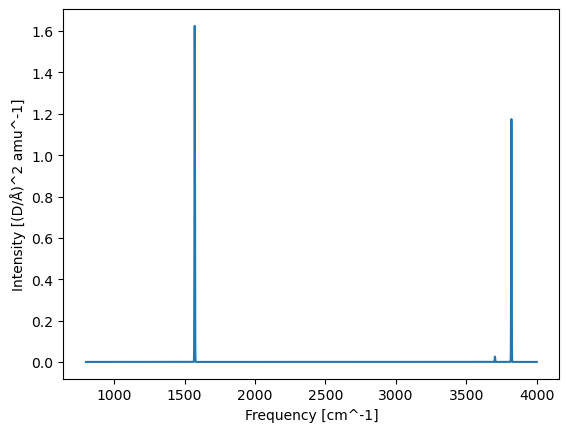

In [37]:
freq, I = ir.get_spectrum()

plt.plot(freq,I)
plt.xlabel('Frequency [cm^-1]')
plt.ylabel('Intensity [(D/Å)^2 amu^-1]')

# Calculando espectro IR usando Phonopy e Phonopy-Spectroscopy

1. Instale PHONOPY no ambiente `quantum` usando o comando abaixo

```bash
conda install -c conda-forge phonopy
```


2. Entre na pasta `home/{seu_usuario}/Programs` do linux, e faça um clone do repositório do `Phonopy-Spectroscopy` através do comando 

```bash
git clone https://github.com/skelton-group/Phonopy-Spectroscopy
```

e acrescente os seguintes comandos ao arquivo `~/.bashrc`

```bash
export PYTHONPATH=${PYTHONPATH}:/home/{seu_usuario}/Programs/Phonopy-Spectroscopy/lib
export PATH=/home/{seu_usuario}/Programs/Phonopy-Spectroscopy/scripts:$PATH
```

e faça os scripts se tornarem executáveis usando

```bash
chmod +x /home/{seu_usuario}/Programs/Phonopy-Spectroscopy/scripts/*
```

In [77]:
calc = Vasp(restart=True,directory='water/relaxed')
water = calc.get_atoms()

In [78]:
calc = Vasp(directory='water/dfpt_gamma_ir',
            xc='PBE',
            encut=450,                 
            algo='Fast',
            ismear=0, sigma=0.01,      # for molecules
            ediff=1e-8,                # tight SCF
            ibrion=-1,                 # Single-Point Force
            isif=2,
            nsw=0,                     # single perturbative step
            nelm = 250,
            prec='Accurate',
            lcharg=False, lreal=False, lwave=False, # no output
            atoms=water
        )
calc.calculate(water)

2. Gera os deslocamentos usando o comando abaixo na pasta `water/dfpt_gamma_ir`

```bash
phonopy -d --dim="1 1 1"
```


3. Lê os arquivos de `POSCAR-00X` gerados e efetua o cálculo de Single Point para cada arquivo separadamente.

In [80]:
for i in range(6):
    w = read(f'water/dfpt_gamma_ir/POSCAR-00{i+1:d}')
    
    calc = Vasp(directory=f'water/dfpt_gamma_ir/disp-00{i+1:d}',
            xc='PBE',
            encut=450,                 
            algo='Fast',
            ismear=0, sigma=0.01,      # for molecules
            ediff=1e-8,                # tight SCF
            ibrion=-1,                 # Single-Point Force
            isif=2,
            nsw=0,                     # single perturbative step
            nelm = 250,
            prec='Accurate',
            lcharg=False, lreal=False, lwave=False, # no output
            atoms=w
        )
    calc.calculate(w)


4. Usa o comando abaixo para ler as forças

```bash
phonopy -f disp-{001..006}/vasprun.xml
```

5. Gere um arquivo `mesh.yaml` usando o comando

```bash
phonopy --dim="1 1 1" --fc-symmetry --mesh="1 1 1" --eigenvectors
```

6. Roda um cálculo de otimização para determinar cargas de Born e tensor dielétrico

In [81]:
calc = Vasp(directory='water/dfpt_gamma_ir',
            xc='PBE',
            encut=450,                 
            algo='Fast',
            ismear=0, sigma=0.01,      # for molecules
            ediff=1e-8,                # tight SCF
            ibrion=7,                  # DFPT Γ phonons (without symmetry)
            nsw=0,                     # single perturbative step
            nelm = 250,
            prec='Accurate',
            lcharg=False, lreal=False, lwave=False, # no output
            lepsilon=True,             # dielectric tensor + Born charges
            lasph=True, addgrid=True,  # usual accuracy flags
            atoms=water
        )
calc.calculate(water)

> Demorou 7 min

7. Em seguida, na pasta `water/dfpt_gamma_ir`, crie o arquivo `BORN` usando o comando

```bash
phonopy-vasp-born > BORN 
```


8. Crie o espectro IR usando o comando 

```bash
phonopy-ir --linewidth=16.5 --spectrum-range="500 4000"
```

9. Lê o arquivo gerado

In [87]:
ir_water_data = np.loadtxt('water/dfpt_gamma_ir/IR-Spectrum.dat', skiprows=1)

Text(0, 0.5, 'Intensity [e^2 amu^-1]')

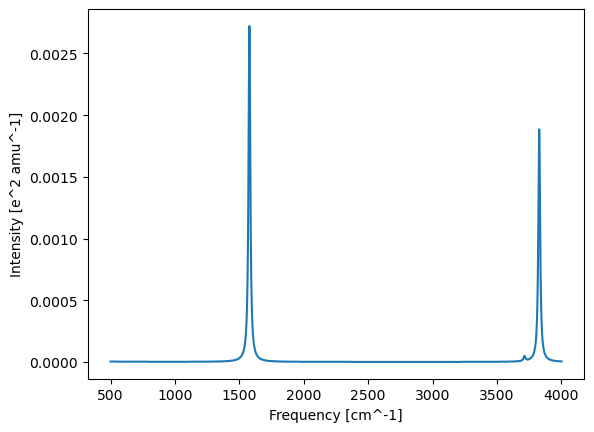

In [89]:
plt.plot(ir_water_data[:,0],ir_water_data[:,1])
plt.xlabel('Frequency [cm^-1]')
plt.ylabel('Intensity [e^2 amu^-1]')

## Molécula de CO2

In [90]:
calc = Vasp(restart=True,directory='co2/relaxed')
co2 = calc.get_atoms()

In [91]:
calc = Vasp(directory='co2/dfpt_gamma_ir',
            xc='PBE',
            encut=450,                 
            algo='Fast',
            ismear=0, sigma=0.01,      # for molecules
            ediff=1e-8,                # tight SCF
            ibrion=-1,                 # Single-Point Force
            isif=2,
            nsw=0,                     # single perturbative step
            nelm = 250,
            prec='Accurate',
            lcharg=False, lreal=False, lwave=False, # no output
            atoms=co2
        )
calc.calculate(co2)

In [ ]:
import os, subprocess

subprocess.run('conda run -n quantum phonopy -d --dim="1 1 1"',cwd='co2/dfpt_gamma_ir', shell=True, check=True)

In [95]:
for i in range(3):
    w = read(f'co2/dfpt_gamma_ir/POSCAR-00{i+1:d}')
    
    calc = Vasp(directory=f'co2/dfpt_gamma_ir/disp-00{i+1:d}',
            xc='PBE',
            encut=450,                 
            algo='Fast',
            ismear=0, sigma=0.01,      # for molecules
            ediff=1e-8,                # tight SCF
            ibrion=-1,                 # Single-Point Force
            isif=2,
            nsw=0,                     # single perturbative step
            nelm = 250,
            prec='Accurate',
            lcharg=False, lreal=False, lwave=False, # no output
            atoms=w
        )
    calc.calculate(w)

In [ ]:
subprocess.run("conda run -n quantum phonopy -f disp-{001..003}/vasprun.xml",cwd='co2/dfpt_gamma_ir', shell=True, check=True)

In [ ]:
subprocess.run('conda run -n quantum phonopy --dim="1 1 1" --fc-symmetry --mesh="1 1 1" --eigenvectors',cwd='co2/dfpt_gamma_ir', shell=True, check=True)

In [96]:
calc = Vasp(directory='co2/dfpt_gamma_ir',
            xc='PBE',
            encut=450,                 
            algo='Fast',
            ismear=0, sigma=0.01,      # for molecules
            ediff=1e-8,                # tight SCF
            ibrion=7,                  # DFPT Γ phonons (without symmetry)
            nsw=0,                     # single perturbative step
            nelm = 250,
            prec='Accurate',
            lcharg=False, lreal=False, lwave=False, # no output
            lepsilon=True,             # dielectric tensor + Born charges
            lasph=True, addgrid=True,  # usual accuracy flags
            atoms=co2
        )
calc.calculate(co2)

> Demorou 7 min

In [98]:
subprocess.run("conda run -n quantum phonopy-vasp-born > BORN",cwd='co2/dfpt_gamma_ir', shell=True, check=True)

CompletedProcess(args='conda run -n quantum phonopy-vasp-born > BORN', returncode=0)

In [99]:
subprocess.run('phonopy-ir --linewidth=16.5 --spectrum-range="500 4000"',cwd='co2/dfpt_gamma_ir', shell=True, check=True)

/bin/sh: line 1: phonopy-ir: command not found


CalledProcessError: Command 'phonopy-ir --linewidth=16.5 --spectrum-range="500 4000"' returned non-zero exit status 127.

In [100]:
ir_co2_data = np.loadtxt('co2/dfpt_gamma_ir/IR-Spectrum.dat', skiprows=1)

Text(0, 0.5, 'Intensity [e^2 amu^-1]')

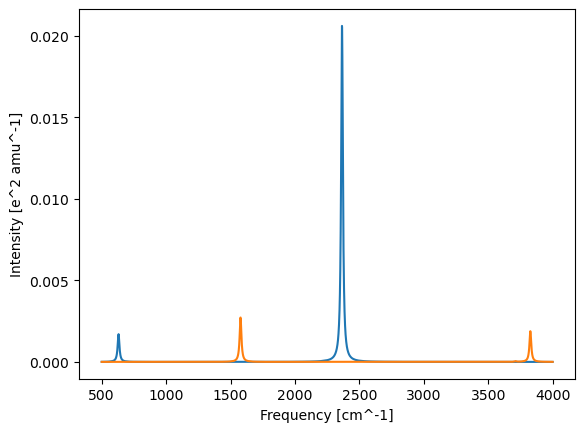

In [102]:
plt.plot(ir_co2_data[:,0],ir_co2_data[:,1])
plt.plot(ir_water_data[:,0],ir_water_data[:,1])
plt.xlabel('Frequency [cm^-1]')
plt.ylabel('Intensity [e^2 amu^-1]')